# A first look at data

date: 12/04/2018

Example code for reading and checking data


In [1]:
import pandas as pd
import dask.dataframe as dd
import glob as glob
import numpy as np
from scipy.stats import kde

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.colors import LogNorm
plt.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

This is the part that reads data and makes a basic selection

In [2]:
df = pd.DataFrame()
df = pd.read_hdf('/data/IceCube/merged2015.h5', key='data')
df['cos2'] = np.cos(df.zenith)**2
df['I'] = 0
df['s125_error'] = 0.1*df['s125']

df.drop(df.columns.difference(['s125', 's125_error',"cos2", "I"]), 1, inplace= True)
df= df.loc[df.s125>25]
df= df.loc[df.cos2>0.5]  
print(df.count())
#df.drop(["Run", "Event"], 1, inplace = True)


s125          37382
cos2          37382
I             37382
s125_error    37382
dtype: int64


In [ ]:
#hist = plt.hist(np.degrees(df.zenith), bins=150)

hist= plt.hist(np.log10(df.s125),bins= 200)

In [3]:

import os
filepath='/home/ioana/src/icecube/Noemi/stage/cic_att' 
os.chdir(filepath)
%run data_functions.py
from data_functions import set_intensity
bins = 10
df.reset_index(inplace=True)
df, groups = set_intensity(df, bins)


In [ ]:
%run data_functions.py
from data_functions import get_data_to_fit
#plt.plot(np.log10(df.s125),np.log10(df.I), 'ro')
vals = get_data_to_fit(df, intensity= 300, n_bins = bins)
print(vals)
plt.errorbar(vals.cos2, vals.s125, yerr = vals.s125_error.tolist(), fmt=".k")
#plt.plot(bin_centers, s125_fit, 'ro')

In [ ]:
fit_vals, cov = get_attenuation_parameters(vals.s125.tolist(), vals.cos2.tolist())
fig2, ax2 =plt.subplots(figsize=(10,6))
plt.grid()
from data_functions import get_s125 
print(fit_vals)
a1=fit_vals[0]
a2=fit_vals[1]
a3=fit_vals[2]
y=get_s125(vals.cos2, a1,a2,a3)
#y2=get_s125(bins, alpha, beta, a3)

ax2.plot(vals.cos2, vals.s125, lw=0, marker='o')
ax2.plot(vals.cos2, y, color="r")
#ax2.plot(bins2,y2)

In [4]:
%run data_functions.py
from tqdm import tqdm

tqdm.pandas(desc="my bar!")

def compute_bootsrap_uncertainties(data, samples, bins, intensity):
    result = []
    for i in tqdm(range(samples)):
        rand_data = get_bootstrap_data(data)
        rand_data, groups = set_intensity(rand_data, bins)
        rand_vals = get_data_to_fit(rand_data, intensity, 10)
        result.append(rand_vals)    
        #print(rand_vals)
    return pd.concat(result)

rand_vals = compute_bootsrap_uncertainties(df, 20, bins, 100)
#print(rand_vals)

  0%|          | 0/20 [00:00<?, ?it/s]/data/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


cos2
0.527829     3.471288
0.583379     5.386339
0.638928    18.189652
0.694478     7.154394
0.750027     8.242105
0.805577     6.621520
0.861126    10.868989
0.916676     7.436699
0.972225     9.816915
Name: s125, dtype: float64


KeyError: 0.0

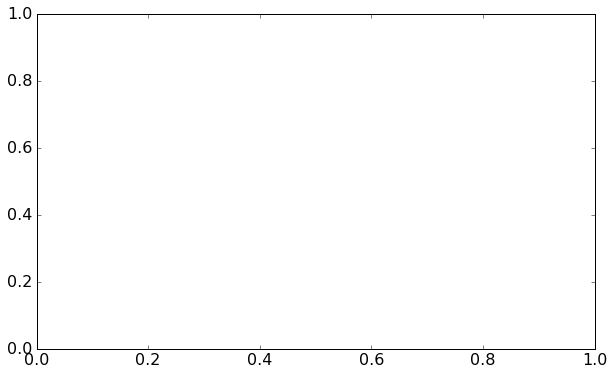

In [19]:
fig2, ax2 =plt.subplots(figsize=(10,6))
groups = rand_vals.groupby(['cos2'])
print(groups.s125.var())
ax2.errorbar(groups.cos2.mean(), groups.s125.mean(), yerr=groups.s125.var(), lw=0, marker='o')

In [ ]:
%run data_functions.py

from data_functions import get_attenuation_parameters2

params_scipy, cov2 = sp.optimize.curve_fit(get_s125, bin_centers, s125_fit)
# Use as guess
a_true = params_scipy[0]
b_true = params_scipy[1]
f_true = params_scipy[2]
print (a_true, b_true, f_true)
#final_parameters, cov2, sample = get_attenuation_parameters2(s125_fit, s38_fit, s125_fit_error, bins, performMCMC=True)
sample = get_attenuation_parameters2(params_scipy, s125_fit, s125_fit_error, bin_centers)

In [ ]:
import math
cos_ref = np.cos(math.radians(38))**2
cos2 = bin_centers - cos_ref
print(len(sample))
# Plot a subset of the samples
for a, b, f in sample[np.random.randint(len(sample), size=200)]:
    plt.plot(cos2, f * (b * cos2**2 + a * cos2 + 1), color="k", alpha=0.1)
    plt.plot(cos2, f_true * (b_true * cos2**2 + a_true * cos2 + 1), color="r", lw=2, alpha=0.8)
    plt.errorbar(bin_centers-cos_ref, s125_fit, yerr=s125_fit_error, fmt=".k")

In [ ]:
import corner
fig = corner.corner(sample, labels=["$a$","$b$", "$s38$"])
fig.savefig("")

In [ ]:
filenames = glob.glob('/data/IceCube/2015/*')
number_of_files = 10000
store = merge_and_select_data(filenames, '/data/IceCube/merged2015.h5', number_of_files )        
dataAll = pd.DataFrame() 
dataAll = store.select('data')
print(dataAll.count())
store.close()    


